In [1]:
import json

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import os

## Checking heavy tails

real all norms

In [2]:
NAMES = ["norms_logs-0.json", "norms_logs-15.json", "norms_logs-31.json", "norms_logs-47.json" ]

HIST_PATHS = {
    "sgd": {
        "none": "/scratch/izar/skorokho/cs439opt_scratch/sgd-none-10.0/",
        "layerwise": "/scratch/izar/skorokho/cs439opt_scratch/sgd-layerwise-5.0/",
        "elementwise": "/scratch/izar/skorokho/cs439opt_scratch/sgd-elementwise-2.5/",
        "global": "/scratch/izar/skorokho/cs439opt_scratch/sgd-global-5.0/",
        "local": "/scratch/izar/skorokho/cs439opt_scratch/sgd-local-2.5/",
    },
    "adam": {
        "none": "/scratch/izar/skorokho/cs439opt_scratch/none-10.0/",
        "layerwise": "/scratch/izar/skorokho/cs439opt_scratch/layerwise-2.5/",
        "elementwise": "/scratch/izar/skorokho/cs439opt_scratch/elementwise-0.1/",
        "global": "/scratch/izar/skorokho/cs439opt_scratch/global-1.0/",
        "local": "/scratch/izar/skorokho/cs439opt_scratch/local-0.1/",
    }
}

In [ ]:
def calc_heaviness(norms_path, coef_1=1.5, coef_2=3):
    """
    Calculate the heaviness statistics for a given norms JSON file.

    Parameters
    ----------
    norms_path : str
        Path to the JSON file containing stochastic norms.
    coef_1 : float, optional
        Coefficient for the mild outlier threshold (default is 1.5).
    coef_2 : float, optional
        Coefficient for the extreme outlier threshold (default is 3).

    Returns
    -------
    tuple
        (mean, std, mild outlier ratio, extreme outlier ratio)
        where ratios are normalized by reference probabilities.
    """
    p_mRN = 0.0035
    p_eRN = 1.2 * 0.000001

    norms_dict = None
    with open(norms_path, "r") as file:
        norms_dict = json.load(file)

    norms = np.array(norms_dict["stochastic_norms"])
    q1 = np.quantile(norms, q=0.25)
    q3 = np.quantile(norms, q=0.75)

    statistic_1 = q3 + coef_1 * (q3 - q1)
    statistic_2 = q3 + coef_2 * (q3 - q1)

    p_mR = sum(norms > statistic_1) / len(norms)
    p_eR = sum(norms > statistic_2) / len(norms)

    return norms.mean(), norms.std(), p_mR / p_mRN, p_eR / p_eRN

heaviness = {}
for opt in HIST_PATHS:
    heaviness[opt] = {}
    for clipping in HIST_PATHS[opt]:
        heaviness[opt][clipping] = {}
        for name in NAMES:
            curr_hist_path = os.path.join(HIST_PATHS[opt][clipping], name)
            heaviness[opt][clipping][name] = calc_heaviness(curr_hist_path)

In [ ]:
def plot_norms(norms_path, xlabel="Noise norm", ylabel="Density", title="Dataset, n steps"):
    """
    Plot the histogram and fitted normal distribution of stochastic norms from a JSON file.

    Parameters
    ----------
    norms_path : str
        Path to the JSON file containing stochastic norms.
    xlabel : str, optional
        Label for the x-axis (default is "Noise norm").
    ylabel : str or None, optional
        Label for the y-axis (default is "Density"). If None, no label is set.
    title : str or None, optional
        Title for the plot (default is "Dataset, n steps"). If None, no title is set.

    Displays
    --------
    A matplotlib histogram of the norms with a fitted normal distribution curve and
    annotated statistics (mean, std, mild/extreme outlier ratios).
    """
    norms_dict = None
    with open(norms_path, "r") as file:
        norms_dict = json.load(file)

    norms = norms_dict["stochastic_norms"]

    ax = plt.gca()    
    ax.hist(norms, color="royalblue", edgecolor="white", bins=100, density=True)

    mu, sigma, ro_mR, ro_eR = calc_heaviness(norms_path)
    x = np.linspace(min(norms), max(norms), 100)
    ax.plot(x, norm.pdf(x, mu, sigma), color="black")
    ax.set_xlabel(xlabel, fontsize=14)
    if not ylabel is None:
        ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)
    textstr = "\n".join(
        (
            r"$\mu=%.2f$" % (mu,),
            r"$\sigma=%.2f$" % (sigma,),
            r"$\rho_{mR}=%.3f$" % (ro_mR,),
            r"$\rho_{eR}=%.0f$" % (ro_eR,),
        )
    )
    ax.text(
        0.7, 0.9, textstr, transform=ax.transAxes, fontsize=14, verticalalignment="top"
    )
    if not title is None:
        ax.set_title(title, fontsize=16)

In [ ]:
# draw for SGD
plt.figure(figsize=(4*5, 5*5))
i_ = 0
for i_c, clipping in enumerate(HIST_PATHS["sgd"]):
    for i_n, name in enumerate(NAMES):
        i_ += 1
        plt.subplot(5, 4, i_)
        ylabel = clipping if i_n == 0 else None
        title = f"Epoch {name[11:-5]}" if i_ <= 4 else None
        plot_norms(os.path.join(HIST_PATHS["sgd"][clipping], name), ylabel=ylabel, title=title)
# plt.savefig("/home/skorokho/coding/Clipped-AdaGrad-and-Adam/ResNet_training/images/cifar_10_sgd_hist.png", dpi=300)
plt.tight_layout()

In [ ]:
# draw for Adam
plt.figure(figsize=(4*5, 5*5))
i_ = 0
for i_c, clipping in enumerate(HIST_PATHS["adam"]):
    for i_n, name in enumerate(NAMES):
        i_ += 1
        plt.subplot(5, 4, i_)
        ylabel = clipping if i_n == 0 else None
        title = f"Epoch {name[11:-5]}" if i_ <= 4 else None
        plot_norms(os.path.join(HIST_PATHS["adam"][clipping], name), ylabel=ylabel, title=title)
# plt.savefig("/home/skorokho/coding/Clipped-AdaGrad-and-Adam/ResNet_training/images/cifar_10_adam_hist.png", dpi=300)
plt.tight_layout()

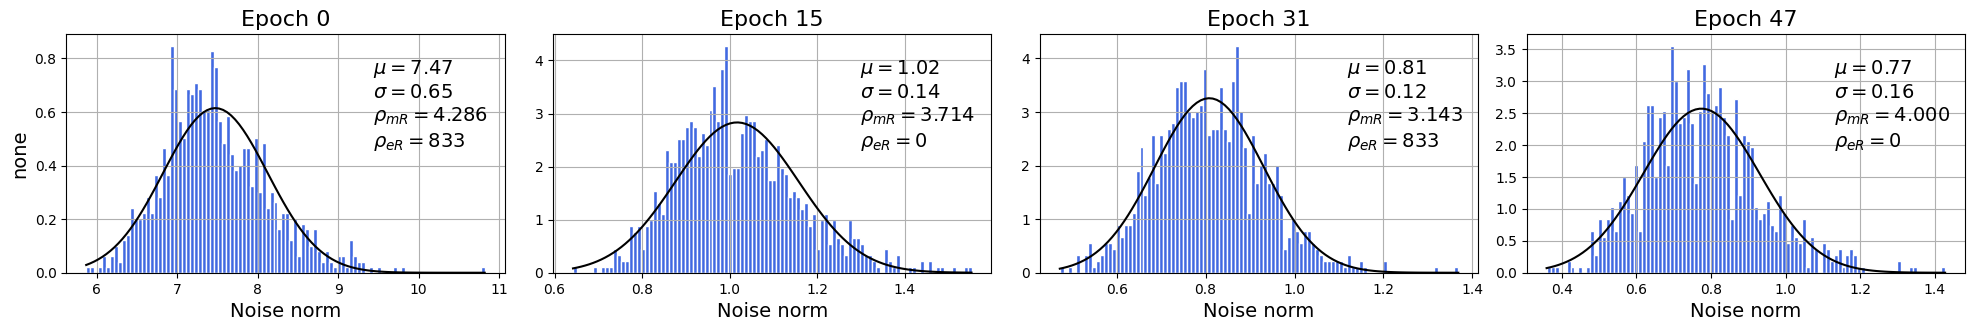

In [ ]:
# draw and save only part of Adam
plt.figure(figsize=(4*5, 1*15))
i_ = 0
clipping = "none"
i_c = 0
for i_n, name in enumerate(NAMES):
    i_ += 1
    plt.subplot(5, 4, i_)
    ylabel = clipping if i_n == 0 else None
    title = f"Epoch {name[11:-5]}" if i_ <= 4 else None
    plot_norms(os.path.join(HIST_PATHS["adam"][clipping], name), ylabel=ylabel, title=title)
plt.savefig(
    "/home/skorokho/coding/Clipped-AdaGrad-and-Adam/ResNet_training/images/cifar_10_adam_hist_none.pdf", 
    dpi=300, 
    bbox_inches="tight",
    format="pdf"
)
plt.tight_layout()

## Model comparison

In [ ]:
def get_mean_line(logs):
    """Return mean values at each step across runs."""
    return np.mean(logs, axis=0)

def get_std_lines(logs):
    """Return (mean+std, mean-std) at each step across runs."""
    logs = np.array(logs)
    mean = logs.mean(axis=0)
    std = logs.std(axis=0)
    return mean + std, mean - std

def get_worst_line(logs, worst_type):
    """Return max or min values at each step across runs."""
    logs = np.array(logs)
    return logs.max(axis=0) if worst_type == "max" else logs.min(axis=0)

def get_quantile_line(logs, q):
    """Return quantile values at each step across runs."""
    return np.quantile(logs, q, axis=0)


In [ ]:
LOG_N_STEP = 10  # replace with your value

PATHS_TO_COMPARE = {
    "adam": [
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/adam-elementwise-multirun/logs.json",
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/adam-local-multirun/logs.json",
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/adam-global-multirun/logs.json",
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/adam-layerwise-miltirun/logs.json",
    ],
    "sgd": [
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/sgd-elementwise-multirun/logs.json",
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/sgd-local-multirun/logs.json",
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/sgd-global-multirun/logs.json",
        "/scratch/izar/skorokho/cs439opt_scratch/multirun/sgd-layerwise-multirun/logs.json",
    ]
}

LABELS = {
    "adam": ["adam-elementwise", "adam-local", "adam-global", "adam-layerwise"],
    "sgd": ["sgd-elementwise", "sgd-local", "sgd-global", "sgd-layerwise"],
}

assert len(PATHS_TO_COMPARE) == len(LABELS)

In [ ]:
def preroc_logs(raw_logs, stage, log_n_step=LOG_N_STEP):
    """
    Preprocess raw logs for training or validation.

    Parameters
    ----------
    raw_logs : list or np.ndarray
        Raw log values to preprocess.
    stage : str
        Either "train" or "val", determines preprocessing method.
    log_n_step : int, optional
        Step size for averaging training logs (default is LOG_N_STEP).

    Returns
    -------
    np.ndarray
        Processed log values, averaged appropriately for the given stage.
    """
    if stage == "train":
        raw_logs = np.array(raw_logs)
        return (
            np.add.reduceat(raw_logs, np.arange(0, len(raw_logs), log_n_step))[:-1]
            / log_n_step
        )
    return np.array([np.array(x).mean() for x in raw_logs if len(x) > 2])

In [ ]:
MODE = "sgd"
logs = []

for i, path in enumerate(PATHS_TO_COMPARE[MODE]):
    log = {"model": {"train_loss": [], "val_loss": [], "val_metric": []}}

    with jsonlines.open(path) as reader:
        for obj in reader:
            log["model"]["train_loss"].append(
                preroc_logs(obj["model"]["train_loss"], "train")
            )
            log["model"]["val_loss"].append(
                preroc_logs(obj["model"]["val_loss"], "val")
            )
            log["model"]["val_metric"].append(
                preroc_logs(obj["model"]["val_metric"], "val")
            )
    logs.append(log)

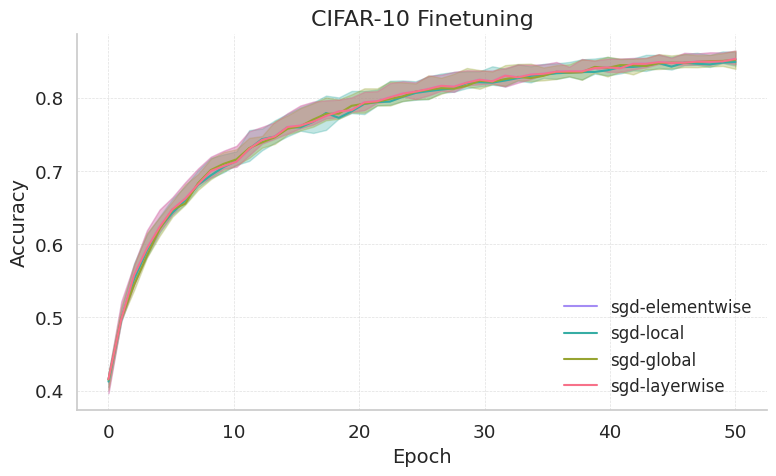

In [ ]:
from copy import deepcopy

METRICS_TYPE = "val_metric" # accuracy in our case

with plt.style.context("seaborn-v0_8-muted"):
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = sns.color_palette("husl", len(logs))[::-1]

    for i_ in range(len(logs)):

        clipped_log = logs[i_]
        metrics = deepcopy(clipped_log["model"][METRICS_TYPE])


        clipped_metrics_high = get_quantile_line(metrics, 0.95)
        clipped_metrics_med = get_quantile_line(metrics, 0.5)
        clipped_metrics_low = get_quantile_line(metrics, 0.05)
        steps = np.linspace(0, 50, len(clipped_metrics_high))
        ax.plot(
            steps, clipped_metrics_med, label=LABELS[MODE][i_], color=colors[i_]
        )
        ax.fill_between(
            steps,
            clipped_metrics_low,
            clipped_metrics_high,
            alpha=0.3,
            color=colors[i_],
        )

    # Aesthetics
    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title("CIFAR-10 Finetuning", fontsize=16)

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(fontsize=12, frameon=False)
    sns.despine()  # Clean look by removing top/right spines

    plt.tight_layout()
    plt.savefig(f"/home/skorokho/coding/Clipped-AdaGrad-and-Adam/ResNet_training/images/cifar_10_{MODE}_big.png", dpi=300)
    plt.show()


zoomed in

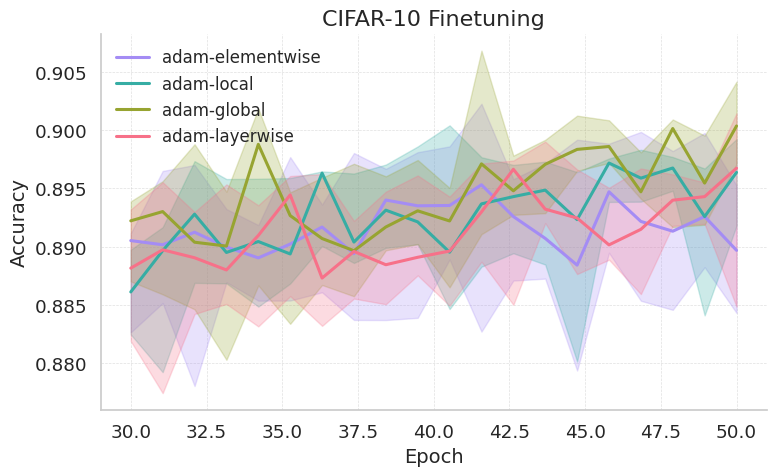

In [90]:
with plt.style.context("seaborn-v0_8-muted"):
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = sns.color_palette("husl", len(logs))[::-1]

    for i_ in range(len(logs)):
        clipped_log = logs[i_]
        metrics = deepcopy(clipped_log["model"][METRICS_TYPE])

        for i in range(len(metrics)):
            metrics[i] = metrics[i][-20:] 

        clipped_metrics_high = get_quantile_line(metrics, 0.95)
        clipped_metrics_med = get_quantile_line(metrics, 0.5)
        clipped_metrics_low = get_quantile_line(metrics, 0.05)
        steps = np.linspace(30, 50, len(clipped_metrics_high))

        ax.plot(
            steps, clipped_metrics_med,
            label=LABELS[i_],
            color=colors[i_],
            linewidth=2.2
        )
        ax.fill_between(
            steps,
            clipped_metrics_low,
            clipped_metrics_high,
            alpha=0.25,
            color=colors[i_]
        )

    # Aesthetics
    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title("CIFAR-10 Finetuning", fontsize=16)

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(fontsize=12, frameon=False)
    sns.despine()  # Clean look by removing top/right spines

    plt.tight_layout()
    plt.savefig("/home/skorokho/coding/Clipped-AdaGrad-and-Adam/ResNet_training/images/cifar_10_adam_small.png", dpi=300)
    plt.show()